In [42]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML

%matplotlib inline

In [43]:
# Enter the begin and end dates for the gage and flow data

begin_date = '2023-01-01T00:00:00.000-05:00'
end_date = '2024-08-28T00:00:00.000-05:00'

#01473730 - Schuylkill River at Conshohocken, PA

In [44]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
gage = gage.iloc[1: , :]


In [45]:
gage['328674_00065'] = gage['328674_00065'].astype(float)
gage = gage[['datetime','328674_00065']]
gage = gage.set_index('datetime')
gage.head()

,328674_00065
datetime,
2023-05-16 12:45,7.18
2023-05-16 13:15,7.18
2023-05-16 13:30,7.19
2023-05-16 13:45,7.19
2023-05-16 14:00,7.16


In [46]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
flow = flow.iloc[1: , :]

In [47]:
flow['328771_00060'] = flow['328771_00060'].astype(float)
flow = flow[['datetime','328771_00060']]
flow = flow.set_index('datetime')
flow.head()

,328771_00060
datetime,
2023-05-16 12:45,1400.0
2023-05-16 13:15,1400.0
2023-05-16 13:30,1410.0
2023-05-16 13:45,1410.0
2023-05-16 14:00,1370.0


In [48]:
# Merge datasets together on datetime index and check if everything is good
df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
df.head()

,328674_00065,328771_00060
datetime,,
2023-05-16 12:45,7.18,1400.0
2023-05-16 13:15,7.18,1400.0
2023-05-16 13:30,7.19,1410.0
2023-05-16 13:45,7.19,1410.0
2023-05-16 14:00,7.16,1370.0


In [49]:
# Rename gage and flow rate colums to something humane and check the dataframe
df = df.rename(columns={"328674_00065": "Gage", "328771_00060": "Flow"  })
df.head()

,Gage,Flow
datetime,,
2023-05-16 12:45,7.18,1400.0
2023-05-16 13:15,7.18,1400.0
2023-05-16 13:30,7.19,1410.0
2023-05-16 13:45,7.19,1410.0
2023-05-16 14:00,7.16,1370.0


In [50]:
#check the number of training rows
print('number of rows = ', df.shape[0])

number of rows =  45920


In [51]:
# Shift Gage readings by X time units and set as training label, calculate gage and flow rates of change 
def gage_forecast(df, forecast):
    df['Gage_forecast_'+str(forecast)] = df['Gage'].shift(-forecast)
    df['Gage_forecast_'+str(forecast_horizon)] = df['Gage_forecast_'+str(forecast_horizon)]
    df['Gage_diff'] = df['Gage'].shift(-1) - df['Gage']
    df['Flow_diff'] = df['Flow'].shift(-1) - df['Flow']
    df.drop(df.tail(forecast).index,inplace=True) # drop last n rows
    return df

In [52]:
# Set the forecast horizon. Note this is in time units, each time unit is 15 minutes. 
forecast_horizon = 12

In [53]:
# Process gage forecast and check results
df = gage_forecast(df, forecast_horizon)
df.tail(200)

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2024-08-25 21:15,6.75,804.0,6.78,0.01,13.0
2024-08-25 21:30,6.76,817.0,6.78,0.00,0.0
2024-08-25 21:45,6.76,817.0,6.77,-0.01,-13.0
2024-08-25 22:00,6.75,804.0,6.78,0.00,0.0
2024-08-25 22:15,6.75,804.0,6.77,0.00,0.0
...,...,...,...,...,...
2024-08-27 21:00,6.73,779.0,6.73,0.00,0.0
2024-08-27 21:15,6.73,779.0,6.73,0.00,0.0
2024-08-27 21:30,6.73,779.0,6.72,0.00,0.0


In [54]:
#df.to_csv('data/checkgagediff.csv')

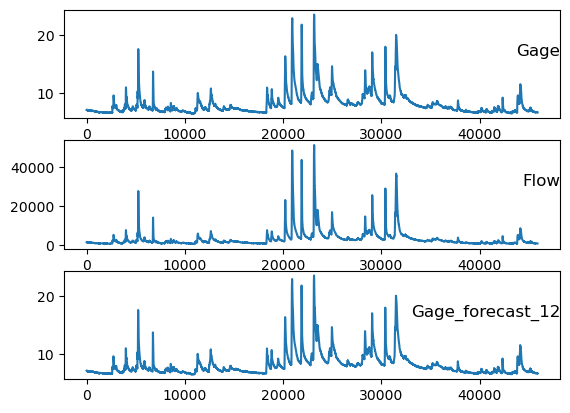

In [55]:
# Make a quick visual of stacked charts - this is a reality check
values = df.values
groups = [0,1,2,]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Text(0, 0.5, 'Gage (ft)')

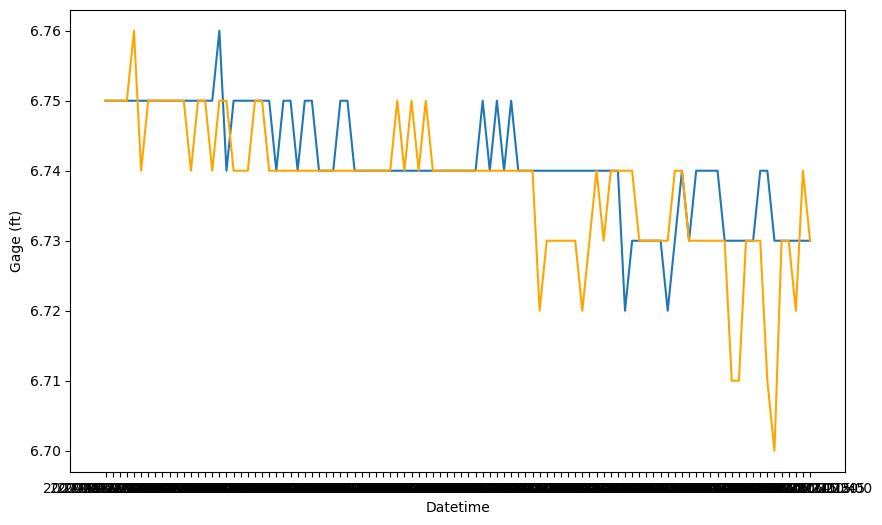

In [56]:
# Check if gage forecast is shifted from gage reading
plt.figure(figsize=(10,6))
plt.plot(df['Gage'].tail(100))
plt.plot(df['Gage_forecast_'+str(forecast_horizon)].tail(100), color = 'orange')
plt.xlabel('Datetime')
plt.ylabel('Gage (ft)')

In [57]:
#Split dataset into training and testing set
df.reset_index(drop=True,inplace=True)
df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]

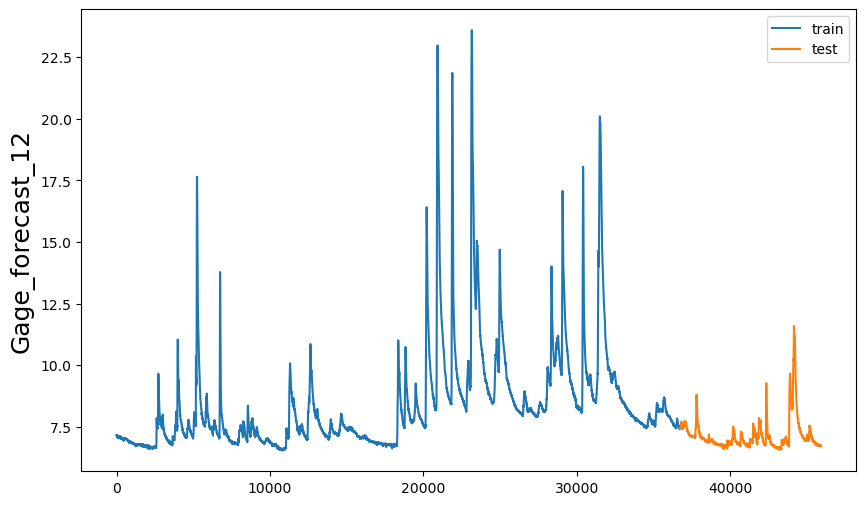

In [58]:
#Check dataset
plt.figure(figsize=(10,6))
plt.plot(df_train.index,df_train['Gage_forecast_'+str(forecast_horizon)])
plt.plot(df_test.index,df_test['Gage_forecast_'+str(forecast_horizon)])
plt.ylabel('Gage_forecast_'+str(forecast_horizon),fontsize=18)
plt.legend(['train','test'])
plt.show()

In [59]:
# Initialize H2O-3 on single node
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmpyv0yklii
  JVM stdout: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmpyv0yklii/h2o_tott_started_from_python.out
  JVM stderr: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmpyv0yklii/h2o_tott_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,8 months and 7 days
H2O_cluster_name:,H2O_from_python_tott_xg3jn0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [60]:
# Load datesets into H2O frames
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [61]:
# Check the dataset
hf_train.describe()

Rows:36727
Cols:5

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
type,real,int,real,real,int
mins,6.55,578.0,6.55,-0.2900000000000027,-1100.0
mean,8.457151414490692,3691.3283960029103,8.457245623111117,7.896098238353596e-06,0.011980286982327703
maxs,23.59,51100.0,23.59,0.6899999999999995,2500.0
sigma,2.14470318465877,4951.220051301692,2.1446531880317976,0.0347903131765947,98.80782893574614
zeros,0,0,0,16060,16379
missing,0,0,0,0,0
0,7.18,1400.0,7.17,0.0,0.0
1,7.18,1400.0,7.14,0.010000000000000677,10.0
2,7.19,1410.0,7.17,0.0,0.0


In [62]:
# Set up the independent variable 'y' and the dependent variables 'X'
#y = 'Gage_forecast_'+str(forecast_horizon)
y = 'Gage_forecast_'+str(forecast_horizon)
X = hf_train.columns
X.remove(y)

In [63]:
# List the columns for training, just for reality check
X

['Gage', 'Flow', 'Gage_diff', 'Flow_diff']

In [64]:
# Set up the H2O-3 AutoML model, run for 10 minutes with RSME as the stopping metric, use test set as validation set.
aml = H2OAutoML(max_runtime_secs = 1200,
                seed = 1234, stopping_metric = "RMSE", nfolds = 0,
                sort_metric = "RMSE")

aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          validation_frame = hf_test, #leaderboard_frame
          )

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,85.0,85.0,28075.0,5.0,5.0,5.0,6.0,31.0,21.564707
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2024-08-28 12:54:23,2 min 41.705 sec,0.0,2.1446240,1.3860775,4.5994121,1.4498193,1.3960902,2.1019761
,2024-08-28 12:54:23,2 min 41.735 sec,5.0,1.3381877,0.8785003,1.7907463,0.9290513,0.8938242,0.8631363
,2024-08-28 12:54:23,2 min 41.764 sec,10.0,0.8522250,0.5617871,0.7262874,0.6024206,0.5780972,0.3629105
,2024-08-28 12:54:23,2 min 41.790 sec,15.0,0.5594634,0.3657709,0.3129993,0.3969492,0.3788567,0.1575687
,2024-08-28 12:54:23,2 min 41.821 sec,20.0,0.3735325,0.2307607,0.1395265,0.2517799,0.2359611,0.0633931
,2024-08-28 12:54:23,2 min 41.848 sec,25.0,0.2688493,0.1532570,0.0722799,0.1716936,0.1535614,0.0294787
,2024-08-28 12:54:23,2 min 41.895 sec,30.0,0.2176206,0.1099354,0.0473587,0.1307810,0.1058064,0.0171037
,2024-08-28 12:54:23,2 min 41.950 sec,35.0,0.1977842,0.0921976,0.0391186,0.1162950,0.0857517,0.0135245


In [65]:
# Check leaderboard
lb = aml.leaderboard

lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20240828_124217_model_138,0.0966031,0.00933216,0.0460475,0.0105303,0.00933216
GBM_grid_1_AutoML_1_20240828_124217_model_43,0.0967866,0.00936765,0.0462477,0.0105438,0.00936765
XGBoost_grid_1_AutoML_1_20240828_124217_model_62,0.0970009,0.00940917,0.0472498,0.010597,0.00940917
GBM_grid_1_AutoML_1_20240828_124217_model_291,0.0976532,0.00953615,0.0469966,0.0106333,0.00953615
XGBoost_grid_1_AutoML_1_20240828_124217_model_12,0.0976911,0.00954356,0.0456958,0.0106005,0.00954356
GBM_grid_1_AutoML_1_20240828_124217_model_272,0.0978834,0.00958117,0.0449714,0.0106668,0.00958117
GBM_grid_1_AutoML_1_20240828_124217_model_266,0.0978903,0.00958251,0.0482355,0.0107232,0.00958251
GBM_grid_1_AutoML_1_20240828_124217_model_55,0.0979172,0.00958777,0.0461394,0.0106444,0.00958777
GBM_grid_1_AutoML_1_20240828_124217_model_99,0.0979886,0.00960177,0.0456393,0.0106533,0.00960177
GBM_grid_1_AutoML_1_20240828_124217_model_223,0.098005,0.00960499,0.0455754,0.0107365,0.00960499


In [66]:
# Select top model on LB as the winner
leader_model = aml.leader

In [67]:
hf_test_predict = leader_model.predict(hf_test)
hf_test_predict.head(5)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
7.4778
7.47252
7.45157
7.47462
7.4778


In [68]:
#contributions = leader_model.predict_contributions(hf_test)
#contributions

In [69]:
#staged_predict_proba = leader_model.staged_predict_proba(hf_test)

In [70]:
#staged_predict_proba

In [71]:
df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Gage'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.tail()

/Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
9177,6.73,6.729472
9178,6.73,6.729472
9179,6.73,6.729472
9180,6.73,6.729472
9181,6.73,6.740581


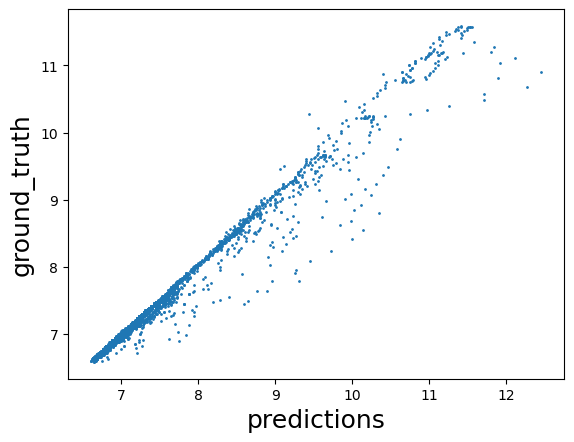

In [72]:
plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

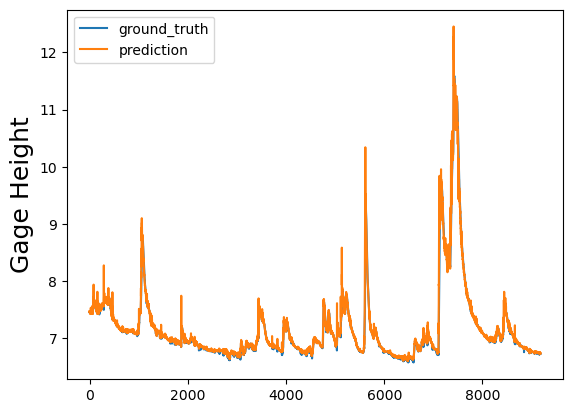

In [73]:
plt.plot(figsize=(20, 5))
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel('Gage Height',fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()

In [74]:
model_path = h2o.save_model(model=aml.leader, path="model/"+str(forecast_horizon)+"_time_units/", force=True)
print (model_path)

/Users/tott/Documents/GitHub/sales-engineering/tott/usgs-site-01473730/model/12_time_units/GBM_grid_1_AutoML_1_20240828_124217_model_138


In [75]:
load_model = h2o.load_model(model_path)
load_model.download_mojo(path="model/"+str(forecast_horizon)+"_time_units/")

'/Users/tott/Documents/GitHub/sales-engineering/tott/usgs-site-01473730/model/12_time_units/GBM_grid_1_AutoML_1_20240828_124217_model_138.zip'

In [76]:
#leader_model.explain(hf_test)

In [77]:
df_results['predictions'][:-48]

0       7.477805
1       7.472517
2       7.451570
3       7.474624
4       7.477805
          ...   
9129    6.745402
9130    6.745402
9131    6.745402
9132    6.745402
9133    6.745402
Name: predictions, Length: 9134, dtype: float64

In [78]:
print(aml.leader.rmse())

0.1641792579056882


In [79]:
h2o.cluster().shutdown()

H2O session _sid_98ba closed.
